# <center>DEEP LEARNING with RNN, LSTM, GRU, and with BayesianCV Optimizer from SciKit-Optimize.</center>

In [1]:
import pandas as pd
import numpy as np

##### We will first load our numpy array data we created from our DataWrangle file.

In [3]:
# load numpy array from npy file
from numpy import load
# load array
X_data = load(r'C:\Your_Path\X_data.npy')
Y_data = load(r'C:\Your_Path\Y_data.npy')
# print the array to see that the shapes are correctly specified
print(X_data.shape)
print(Y_data.shape)

(7702, 2, 919)
(7702, 1, 1)


##### Let's now create our typical Train-test split along with our validation data set.

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=4)

# We further split our training datasets (X_train and y_train) into a train2 (X and y) set and a validation set (X_val and y_val)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=4)

In [5]:
# Let's check the shapes. Dimensionality should be the same for all sets = 3D.
print(X_train.shape, X_train2.shape, X_val.shape, X_test.shape, y_train.shape, y_train2.shape, y_val.shape, y_test.shape)

(6161, 2, 919) (4928, 2, 919) (1233, 2, 919) (1541, 2, 919) (6161, 1, 1) (4928, 1, 1) (1233, 1, 1) (1541, 1, 1)


## Model building

##### We will here need to import A LOT of packages because we are doing everything! RNN... LSTM... GRU... different layers etc.

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import InputLayer
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2
import matplotlib.pyplot as plt

## Simple RNN
##### This simple RNN is a recurrent neural network which we can simply build. It contains one input layer, one simpleRNN layer, and one output layer.

In [7]:
model_simpleRNN = keras.Sequential()
model_simpleRNN.add(InputLayer(input_shape=(2, 919)))
model_simpleRNN.add(SimpleRNN(10, activation='tanh', return_sequences=False))
model_simpleRNN.add(Dense(1, activation='sigmoid'))
print(model_simpleRNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                9300      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 9,311
Trainable params: 9,311
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# next to compile our model we need to specify a few things, such as the Adam optimizer, the learning rate, and loss function, and AUC

model_simpleRNN.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   loss='binary_crossentropy',
                   metrics=['AUC'])

In [9]:
# Next, we will need to define our batch size, which is how many samples to run at once
# and the epoch, which specifies when a dataset has been fully parsed through by our model which will calculate our loss and AUC fit.

batch_size = 128
epochs = 1000

# We instance early stopping here, which allows us to specify validation auc
# as our performance measure to monitor, and the mode allows us to specify
# that we are trying to objectively increase our validation AUC.

# If instead of AUC or accuracy, we monitor val_loss (validation loss), we
# would then want to select 'min' as our mode because we would want to minimize
# our loss. Verbose set to one allows us to discover our training epoch that was stopped.
# We add patience=10 to delay the number of epochs run which we don't see improvements.

es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=10, restore_best_weights=True)

history_simpleRNN = model_simpleRNN.fit(X_train2, y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[es] # note callback can be passed thru fit, evaluate, predict to look into various stages of model training and specifics
                                   # In this case, we are use callback to pull out what epochs and the model parameters.
                    )

# evaluate the model
_, simpleRNN_train_auc = model_simpleRNN.evaluate(X_train, y_train, verbose=0)
_, simpleRNN_test_auc = model_simpleRNN.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (simpleRNN_train_auc, simpleRNN_test_auc))

Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
Train: 0.917, Test: 0.728


range(1, 29)


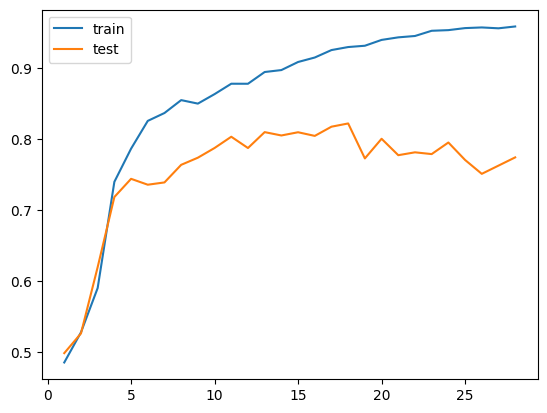

In [10]:
# plot training history
epoch_count = range(1, len(history_simpleRNN.history['auc']) + 1)
print(epoch_count)
plt.plot(epoch_count, history_simpleRNN.history['auc'], label='train')
plt.plot(epoch_count, history_simpleRNN.history['val_auc'], label='test')
plt.legend()
plt.show()

# We see that our best epoch was determiend to be weights, biases, and params
# from epoch 18, but of course patience=10 extended the training into 28 which finally triggered our earlystop.
# In this graph, we see that we are starting to overfit our training data, and that our 
# testing data caps at between 0.7-0.8 AUC.

## LSTM

In [11]:
# Now let's begin with a very simple LSTM model with one input, one LSTM layer, and an output dense layer.
model_lstm = keras.Sequential()
model_lstm.add(InputLayer(input_shape=(2, 919)))
model_lstm.add(LSTM(10, activation='tanh', return_sequences=False))
model_lstm.add(Dense(1, activation='sigmoid'))
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                37200     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 37,211
Trainable params: 37,211
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   loss='binary_crossentropy',
                   metrics=['AUC'])

In [13]:
batch_size = 128
epochs = 1000

# patient early stopping
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=10, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train2, y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[es]
                    )

# evaluate the model
_, lstm_train_auc = model_lstm.evaluate(X_train, y_train, verbose=0)
_, lstm_test_auc = model_lstm.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (lstm_train_auc, lstm_test_auc))

Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
Train: 0.911, Test: 0.774


range(1, 29)


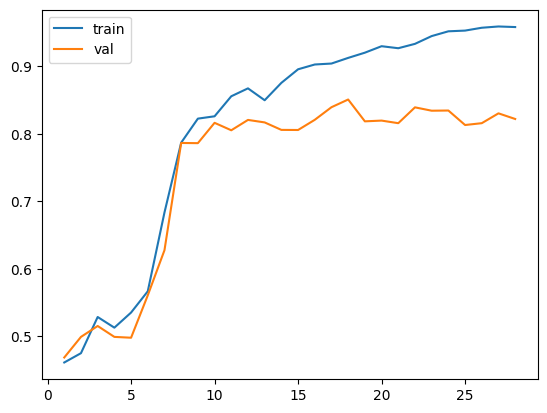

In [14]:
# plot training history
epoch_count = range(1, len(history_lstm.history['auc']) + 1)
print(epoch_count)
plt.plot(epoch_count, history_lstm.history['auc'], label='train')
plt.plot(epoch_count, history_lstm.history['val_auc'], label='val')
plt.legend()
plt.show()

# Once again, our LSTM performed relatively similar to our simple RNN.
# Reasons for this likely is because LSTM does much better with sequential data
# that has multiple periods. In our data, we ONLY have 2 time periods (years 0 and 3)
# that were used to make predictions on time point 3 (year 6)...
# And so, the results for our very simple LSTM were much more like the RNN.

## GRU

In [15]:
# Let's keep trying with an additional model, but this time a GRU instanced in the same format as our simple RNN and LSTM.
model_GRU = keras.Sequential()
model_GRU.add(InputLayer(input_shape=(2, 919)))
model_GRU.add(GRU(10, activation='tanh', return_sequences=False))
model_GRU.add(Dense(1, activation='sigmoid'))
print(model_GRU.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10)                27930     
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 27,941
Trainable params: 27,941
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
model_GRU.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   loss='binary_crossentropy',
                   metrics=['AUC'])

In [17]:
batch_size = 128
epochs = 1000

# patient early stopping
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=10, restore_best_weights=True)

history_GRU = model_GRU.fit(X_train2, y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[es]
                    )

# evaluate the model
_, GRU_train_auc = model_GRU.evaluate(X_train, y_train, verbose=0)
_, GRU_test_auc = model_GRU.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (GRU_train_auc, GRU_test_auc))

Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
Train: 0.924, Test: 0.757


range(1, 29)


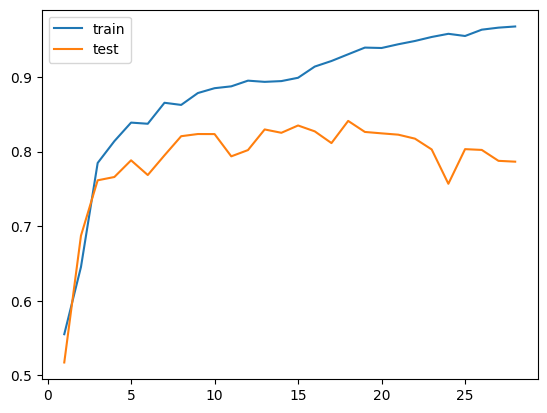

In [18]:
# plot training history
epoch_count = range(1, len(history_GRU.history['auc']) + 1)
print(epoch_count)
plt.plot(epoch_count, history_GRU.history['auc'], label='train')
plt.plot(epoch_count, history_GRU.history['val_auc'], label='test')
plt.legend()
plt.show()

# Once again, just like our LSTM model, the GRU performed relatively similar to our simple RNN.
# Objectively, it appears there are no significant differences between the RNN, LSTM, and GRU
# when the sequence of data we feed are not long. However, if we had multiple years of follow-up data
# Then perhaps the simple RNN will begin to fade out with either vanishing or exploding gradient problem.

## LSTM + GRU

In [19]:
# Will there be a difference if we add one LSTM layer, and one GRU layer?? Let's find out.

model_lsRU = keras.Sequential()
model_lsRU.add(InputLayer(input_shape=(2, 919)))
model_lsRU.add(LSTM(10, activation='tanh', return_sequences=True))
model_lsRU.add(GRU(10, activation='tanh', return_sequences=False))
model_lsRU.add(Dense(1, activation='sigmoid'))
print(model_lsRU.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 10)             37200     
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 37,871
Trainable params: 37,871
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model_lsRU.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   loss='binary_crossentropy',
                   metrics=['AUC'])

In [21]:
batch_size = 128
epochs = 1000

# patient early stopping
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=10, restore_best_weights=True)

history_lsRU = model_lsRU.fit(X_train2, y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[es]
                    )

# evaluate the model
_, lsRU_train_auc = model_lsRU.evaluate(X_train, y_train, verbose=0)
_, lsRU_test_auc = model_lsRU.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (lsRU_train_auc, lsRU_test_auc))

Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping
Train: 0.926, Test: 0.746


range(1, 31)


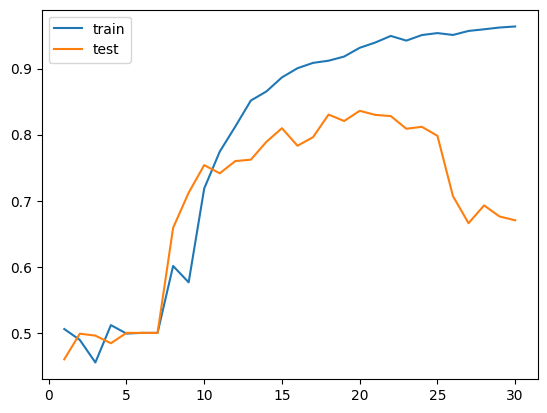

In [22]:
# plot training history
epoch_count = range(1, len(history_lsRU.history['auc']) + 1)
print(epoch_count)
plt.plot(epoch_count, history_lsRU.history['auc'], label='train')
plt.plot(epoch_count, history_lsRU.history['val_auc'], label='test')
plt.legend()
plt.show()

# It does not significantly improve upon our testing AUC as it seems.

## SimpleRNN plus an additional dense/hidden layer with 10 nodes

In [23]:
# Going back to our most basic RNN model, let's add one additional hidden layer with 10 nodes
# And see how this improves/decreases model performance.

model_simpleRNN2 = keras.Sequential()
model_simpleRNN2.add(InputLayer(input_shape=(2, 919)))
model_simpleRNN2.add(SimpleRNN(10, activation='tanh', return_sequences=False, dropout=0.2))
model_simpleRNN2.add(Dense(10, activation='relu'))
model_simpleRNN2.add(Dense(1, activation='sigmoid'))
print(model_simpleRNN2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                9300      
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,421
Trainable params: 9,421
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model_simpleRNN2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   loss='binary_crossentropy',
                   metrics=['AUC'])

In [25]:
batch_size = 128
epochs = 1000

# patient early stopping
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=10, restore_best_weights=True)

history_simpleRNN2 = model_simpleRNN2.fit(X_train2, y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[es]
                    )

# evaluate the model
_, simpleRNN2_train_auc = model_simpleRNN2.evaluate(X_train, y_train, verbose=0)
_, simpleRNN2_test_auc = model_simpleRNN2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (simpleRNN2_train_auc, simpleRNN2_test_auc))

Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
Train: 0.899, Test: 0.759


range(1, 29)


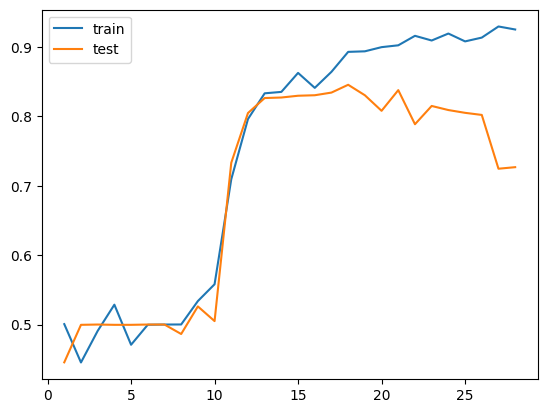

In [26]:
# plot training history
epoch_count = range(1, len(history_simpleRNN2.history['auc']) + 1)
print(epoch_count)
plt.plot(epoch_count, history_simpleRNN2.history['auc'], label='train')
plt.plot(epoch_count, history_simpleRNN2.history['val_auc'], label='test')
plt.legend()
plt.show()

# Still not a significant change as above.

# Hyperparameter tuning

##### Given that now we have tried multiple different combos (RNN, LSTM, GRU, and combos of them all), we still see that our AUC is pretty much capped at the 0.7-0.8 region for our testing sets. This is where the concept of hyperparameter tuning comes into play. We will now begin our BayesianCV Optimization from Sci-Kit Optimize in order to truly find a model which we believe gives us the best AUC aka fit. To simplify things, we will only use this on an LSTM model.

In [27]:
# We will need to import a ton of packages from sci-kit Optimize (skopt) in order for this
# to work.
from skopt import gp_minimize, BayesSearchCV, dump, load
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from keras.wrappers.scikit_learn import KerasClassifier

## gp_minimize

##### gp_minimize is skopt's Bayesian optimiziation function which uses the Gaussian Process. This is used because if the function evaluation process is expensive, a standard optimization using gridsearch or randomsearch would take a very, very long time.

##### The idea here is to approximate a search function using the Gaussian process, which takes the function values that follows a multivariate gaussian with the covariance given by a GP kernel between the parameters. The next parameter chosen to be evaluated then can be made by an acquisition function over the Gaussian prior, and this will make the tuning much quicker to execute.

##### For more info on this, check out this skopt link: https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html

##### Also a shout out to Ryan Mardani's blog post here which was mainly borrowed to construct the optimization process in our instance: https://towardsdatascience.com/bayesian-hyper-parameter-optimization-neural-networks-tensorflow-facies-prediction-example-f9c48d21f795

In [28]:
# Let's first set some fixed values.
num_timestamp = 2 # we have 2 because of 2 follow up years
num_features = 919
num_output = 1 # 1 output classifying either 0=no heart fail; 1=heart fail.
epochs = 1000
batch_size = 128

In [35]:
# Now let's begin to define our search space with all the potential hyperparameters that can be tried.
dim_num_lstm_layers = Integer(low=0, high=3, name='num_lstm_layers')
dim_num_lstm_nodes = Categorical([5, 10, 20, 30], name='num_lstm_nodes')
dim_act_lstm = Categorical(['tanh', 'sigmoid'], name='act_lstm')

dim_num_dense_layers = Integer(low=0, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=1, high=30, name='num_dense_nodes')
dim_act_dense = Categorical(['relu', 'tanh', 'sigmoid', 'softmax'], name='act_dense')

dim_act_last = Categorical(['sigmoid', 'softmax'], name='act_last')

dim_l1_lambda = Categorical([0.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], name='l1_lambda')
dim_l2_lambda = Categorical([0.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], name='l2_lambda')
dim_dropout_rate = Categorical([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], name='dropout_rate') # drop out is a regularization format to avoid overfitting. 
                                                                                    # Default interpretation her is probability of training a given node (1.0=no dropout; 0.0=no output)

dim_learning_rate = Real(low=1e-5, high=1e-1, prior="log-uniform", name='learning_rate')

dimensions = [dim_num_lstm_layers, dim_act_lstm, dim_num_lstm_nodes, dim_dropout_rate, dim_num_dense_layers, dim_num_dense_nodes, 
              dim_act_dense, dim_learning_rate, dim_l1_lambda, dim_l2_lambda, dim_act_last] # This creates one searchable list for all our hyperparameters defined above.

In [36]:
# Let's now define our model function here, which we have to specify how we are going to loop through the dimensions we created earlier.

# 1. We will create our model function
def create_model(num_lstm_layers, act_lstm, num_lstm_nodes, dropout_rate, num_dense_layers, num_dense_nodes, act_dense, 
                 learning_rate, l1_lambda, l2_lambda, act_last):
    # Just like before, let's start with a sequential model.

    model = Sequential()

    # Initialize an input layer first.
    model.add(InputLayer(input_shape=(num_timestamp, num_features)))

    # Initialize the first LSTM layers by looping through each value of 'num_lstm_layers'
    for i in range(num_lstm_layers):
        # We can name each layer though Keras will give them by default too.
        name = 'layer_lstm_{0}'.format(i+1)

        # For each LSTM layers specify the nodes, act function, name, drop out rate, and regularizers.
        model.add(LSTM(np.int32(num_lstm_nodes),
                       activation=str(act_lstm),
                       name=name,
                       return_sequences=True,
                       dropout=dropout_rate,
                       recurrent_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda)))
    
    # Initialize one more LSTM layer prior to adding dense layers
    model.add(LSTM(np.int32(num_lstm_nodes),
                       activation=str(act_lstm),
                       return_sequences=False))
    
    # Initialize a series of dense layers specified by 'num_dense_layers'
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)

        # For each dense/hidden layer, specify nodes, activation function, and the name.
        model.add(Dense(np.int32(num_dense_nodes),
                        activation=str(act_dense),
                        name=name))
    
    # Initialize the last dense layer, and specify how many output nodes.
    model.add(Dense(num_output, activation=str(act_last)))

    # Finally, compile our model with a binary cross entropy loss function and the ADAM optimizer.
    model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate),
              metrics=['AUC'])    
    return model

In [37]:
# 2. Create a log file to keep track all the models and the hyperparameters we are tuning.
def log_dir_name(num_lstm_layers, act_lstm, num_lstm_nodes, dropout_rate, num_dense_layers, num_dense_nodes, act_dense, 
                 learning_rate, l1_lambda, l2_lambda, act_last):
    # The dir-name for the TensorBoard log-dir.
    s = os.path.join(log_path, "lr_{0:.0e}_kernel_{1}_dense_{2}/")
    
    log_dir = s.format(num_lstm_layers, act_lstm, num_lstm_nodes, dropout_rate, num_dense_layers, num_dense_nodes, act_dense, 
                       learning_rate, l1_lambda, l2_lambda, act_last)
    return log_dir

log_path = 'C:/Your_Path/WHIchf_skopt_log'
if not os.path.exists(log_path):
    os.makedirs(log_path)
result_path = 'C:/Your_Path/WHIchf_skopt_result'
if not os.path.exists(result_path):
    os.makedirs(result_path)
path_best_model = os.path.join(result_path+'best_model.keras')
best_auc = 0.0

In [38]:
# 3. We then create a fitness function, which fits the model and returns a fitness value and the AUC score.
@use_named_args(dimensions=dimensions)
def fitness(num_lstm_layers, act_lstm, num_lstm_nodes, dropout_rate, num_dense_layers, num_dense_nodes, act_dense, 
            learning_rate, l1_lambda, l2_lambda, act_last):
    # Print the hyper-parameters.
    print('num_lstm_layers:', num_lstm_layers)
    print('activation_lstm:', act_lstm)
    print('num_lstm_nodes:', num_lstm_nodes)
    print('dropout_rate:', dropout_rate)
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation_dense:', act_dense)
    print('learning_rate: {0:.1e}'.format(learning_rate))
    print('l1_lambda: {0:.1e}'.format(l1_lambda))
    print('l2_lambda: {0:.1e}'.format(l2_lambda))
    print('act_last:', act_last)
    print()
    # Create the neural network model now with the create_model function earlier with these hyper-parameters.
    model = create_model(num_lstm_layers, act_lstm, num_lstm_nodes, dropout_rate, num_dense_layers, num_dense_nodes, act_dense, 
            learning_rate, l1_lambda, l2_lambda, act_last)
     
    # Creates log files with all hyperparameters from earlier.
    log_dir = log_dir_name(num_lstm_layers, act_lstm, num_lstm_nodes, dropout_rate, num_dense_layers, num_dense_nodes, act_dense, 
            learning_rate, l1_lambda, l2_lambda, act_last)
     
    # Create a callback-function for Keras which will be run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
    
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=20, restore_best_weights=True)
    
    # Use Keras to train the model.
    history = model.fit(X_train2, y_train2,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[es, callback_log])
                        
    # Get the classification AUC on the validation-set
    # after the last training-epoch.
    auc = history.history['val_auc'][-1]

    # Print the classification AUC.
    print()
    print("Validation AUC: {0:.2%}".format(auc))
    print()
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_auc

    # If the classification auc of the saved model is improved ...
    if auc > best_auc:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_auc = auc

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    keras.backend.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # auc, we need to negate this number so it can be minimized.
    return -auc

In [39]:
# 4. Define our initial hyperparameters for search
default_parameters = [0, 'tanh', 10, 0.0, 0, 1, 'sigmoid', 1e-3, 0.0, 0.0, 'sigmoid']

num_lstm_layers: 0
activation_lstm: tanh
num_lstm_nodes: 10
dropout_rate: 0.0
num_dense_layers: 0
num_dense_nodes: 1
activation_dense: sigmoid
learning_rate: 1.0e-03
l1_lambda: 0.0e+00
l2_lambda: 0.0e+00
act_last: sigmoid

Epoch 1/1000
39/39 [==============================] - 3s 19ms/step - loss: 0.1535 - auc: 0.5255 - val_loss: 0.0898 - val_auc: 0.5276
Epoch 2/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.0974 - auc: 0.5590 - val_loss: 0.0891 - val_auc: 0.6048
Epoch 3/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.0966 - auc: 0.6925 - val_loss: 0.0885 - val_auc: 0.6750
Epoch 4/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.0953 - auc: 0.7176 - val_loss: 0.0875 - val_auc: 0.7354
Epoch 5/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.0937 - auc: 0.8105 - val_loss: 0.0865 - val_auc: 0.7797
Epoch 6/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.0923 - auc: 0.8195 - val_loss: 0.0853 - 

[(-0.8302116394042969,
  [1,
   'tanh',
   20,
   0.4,
   0,
   19,
   'sigmoid',
   0.0001641215952170319,
   0.0001,
   0.0,
   'sigmoid']),
 (-0.8290481567382812,
  [0,
   'sigmoid',
   30,
   0.4,
   0,
   5,
   'relu',
   0.00021155608067402554,
   0.1,
   0.0,
   'sigmoid']),
 (-0.8178815245628357,
  [1,
   'tanh',
   20,
   0.4,
   0,
   17,
   'relu',
   0.00020647421250237624,
   0.001,
   0.0,
   'sigmoid']),
 (-0.813321053981781,
  [1,
   'tanh',
   20,
   0.5,
   0,
   16,
   'relu',
   0.00018212677299990075,
   0.0,
   0.0,
   'sigmoid']),
 (-0.8131333589553833,
  [2,
   'tanh',
   30,
   0.4,
   0,
   5,
   'sigmoid',
   0.005472679913214501,
   0.1,
   0.0001,
   'sigmoid']),
 (-0.8077471256256104,
  [1,
   'tanh',
   20,
   0.4,
   0,
   1,
   'relu',
   0.00017584221319521715,
   0.0,
   0.0,
   'sigmoid']),
 (-0.8059830665588379,
  [1,
   'tanh',
   20,
   0.4,
   0,
   5,
   'sigmoid',
   0.00023813745390309496,
   0.001,
   1e-06,
   'sigmoid']),
 (-0.8008220195770

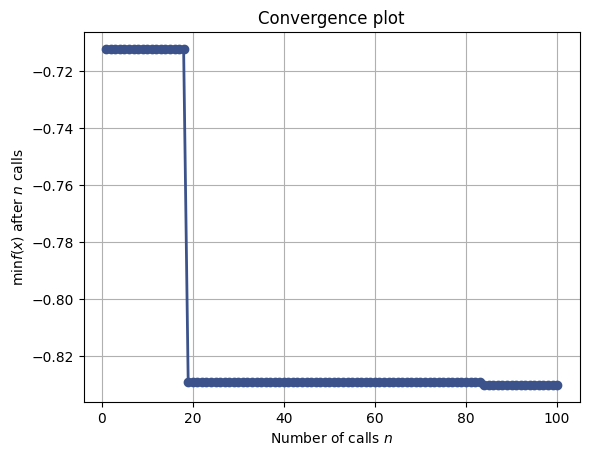

In [40]:
# 5. Begin the tuning process with Bayesian optimization using Gaussian Processes through gp_minimize from skopt
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=100, # min n_calls=11
                            x0=default_parameters)

# save the search result for future use
dump(search_result,result_path+'search_result.gz', compress=9)
# if you need to reload the optimization history, use the following command
#res_load = load(result_path+'search_result.gz')

# check the optimization result
plot_convergence(search_result)

# check the optimized solution
search_result.x

# Evaluate the performance of the best model on the test set
model_best = keras.models.load_model(path_best_model)
train_score = model_best.evaluate(X_train, y_train, verbose=0)
test_score = model_best.evaluate(X_test, y_test, verbose=0)
print('Train loss:', train_score[0])
print('Train AUC:', train_score[1])
print('Test loss:', test_score[0])
print('Test AUC:', test_score[1])

# check the optimization history by listing the combination of all x and 
# its corresponding funtion value
sorted(zip(search_result.func_vals, search_result.x_iters))

In [41]:
# Let's now save our best model
result_path = 'C:/Your_Path/WHIchf_skopt_result'
path_best_model = os.path.join(result_path+'best_model.keras')
model_best = keras.models.load_model(path_best_model)

In [42]:
# We now want to visualize and see how our best model did
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model_best.predict(X_test)
true = y_test.reshape(1541, 1)
fpr, tpr, threshold = metrics.roc_curve(true, probs)
roc_auc = metrics.auc(fpr, tpr)

49/49 [==============================] - 1s 7ms/step


In [45]:
# Our best AUC score
roc_auc

0.767028377376166

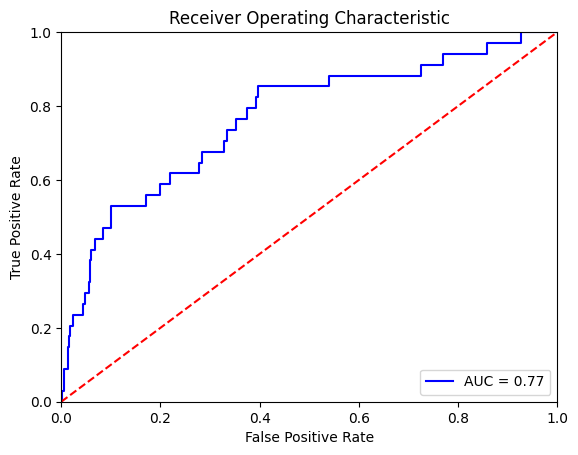

In [46]:
# We can plot our AUC on the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Epilogue

##### As we can see, the LSTM model is a specific type of neural network model which does well with long sequential data. In our case, however, we only had two time points (years 0 and 3), and thus the prediction of our model didn't do much better than a standard RNN. I suppose that we can also do a bit better with respect to the parameters and tuning we had, but once again, like the factorization machine model the limitation is in the computing resources I'm unfortunately limited to.

##### The differences in our neural network approach compared to the FAFM approach is that instead of hand-picked variables we threw in just about every variable under the sun. This neural network model had over 919 variables, and could've been more had we not excluded all variables with >90% missing data!

##### As we conclude, both types of modeling I have introduced so far relies on making predictions. The next series will explore how we can take the modeling approach and start trying to make causal inferences, which is what we really like to explore in epidemiology.